<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 MLR, Analysis of Variance (ANOVA) & Residual (Shadow Fading) Distribution Analysis 
</p>

In [2]:
# ============================== Core & Data Libraries ==============================
import os                                   # File and directory operations
import pickle                               # Object serialization
import numpy as np                          # Numerical computations
import pandas as pd                         # Data manipulation and analysis

# ============================== Visualization Libraries ============================
import matplotlib.pyplot as plt              # Static plots and figures
from matplotlib.ticker import MultipleLocator # Axis tick control
from matplotlib.lines import Line2D          # Custom legend elements
import seaborn as sns                       # Statistical data visualization

# ============================== Machine Learning & Stats ===========================
from sklearn.mixture import GaussianMixture                   # Gaussian mixture models
from sklearn.metrics import mean_squared_error, r2_score      # Model evaluation metrics

from scipy.optimize import curve_fit                # Curve fitting, optimization
from scipy.stats import kstest, norm, t, skewnorm, cauchy     # Specific probability distributions
from scipy.interpolate import interp1d                        # 1D interpolation

import statsmodels.api as sm                                  # Advanced statistical modeling
import statsmodels.formula.api as smf                         # Formula-based regression

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Dataset: Load Saved Splits and Fold Assignments
</p>

In [4]:
# Path to the standardized database directory
base_path = '../Extended Parametric Regression Files+Plots'

# Load train and test splits
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

# Extract features and targets
feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]
X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

# (Should we need 'time' for plotting)
time_train = df_train['time'].values
time_test = df_test['time'].values

# Print number of samples in train and test sets
print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Load 5-fold assignments (array of fold numbers for each train sample)
fold_assignments = np.load(f"{base_path}/train_folds.npy")

# Print fold distribution
unique, counts = np.unique(fold_assignments, return_counts=True)
print(dict(zip(unique, counts)))

print('\nDataset loaded successfully!\n')


Training samples: 1415913, Test samples: 353979
{np.int64(0): np.int64(283183), np.int64(1): np.int64(283183), np.int64(2): np.int64(283183), np.int64(3): np.int64(283182), np.int64(4): np.int64(283182)}

Dataset loaded successfully!



<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Multiple Linear Regression (MLR) Model
</p>

In [6]:
# =================== Model Function ===================

def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w,
                                           a_co2, a_hum, a_pm25,
                                           a_pres, a_temp, k_snr):
    """
    Path loss model with environmental parameters.
    x: 2D array (10, N), where:
       x[0]=distance, x[1]=frequency, x[2]=c_walls, ..., x[9]=snr
    """
    d, frequency, c_walls, w_walls, co2, humidity, pm25, pressure, temperature, snr = x
    d0 = 1  # Reference distance
    return (PL_d0
            + 10 * n * np.log10(d / d0)
            + 20 * np.log10(frequency)
            + c_walls * L_c
            + w_walls * L_w
            + a_co2 * co2
            + a_hum * humidity
            + a_pm25 * pm25
            + a_pres * pressure
            + a_temp * temperature
            + snr * k_snr)


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 5-Fold Cross-Validation on Training Set
</p>

In [8]:
# =================== 5-Fold Cross-Validation (Training set) ===================

initial_guesses = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]

rmse_train_folds, rmse_val_folds = [], []
r2_train_folds, r2_val_folds = [], []
cv_coeffs = []

for fold_num in range(5):
    tr_idx = np.where(fold_assignments != fold_num)[0]
    val_idx = np.where(fold_assignments == fold_num)[0]
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]
    X_tr_T, X_val_T = X_tr.T, X_val.T

    popt, _ = curve_fit(
        log_distance_path_loss_with_env_params, X_tr_T, y_tr,
        p0=initial_guesses, maxfev=100000
    )
    cv_coeffs.append(popt)

    # Training fold metrics
    y_tr_pred = log_distance_path_loss_with_env_params(X_tr_T, *popt)
    rmse_train = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    r2_train = r2_score(y_tr, y_tr_pred)
    rmse_train_folds.append(rmse_train)
    r2_train_folds.append(r2_train)

    # Validation fold metrics
    y_val_pred = log_distance_path_loss_with_env_params(X_val_T, *popt)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)
    rmse_val_folds.append(rmse_val)
    r2_val_folds.append(r2_val)

    print(f"Fold {fold_num+1}: RMSE_train={rmse_train:.4f}, RMSE_val={rmse_val:.4f}")

print("\n=== Cross-Validation Results on the training set ===")
print(f"RMSE (Train): {np.mean(rmse_train_folds):.4f} ± {np.std(rmse_train_folds):.4f}")
print(f"RMSE (Val):   {np.mean(rmse_val_folds):.4f} ± {np.std(rmse_val_folds):.4f}")
print(f"R2 (Train):   {np.mean(r2_train_folds):.4f} ± {np.std(r2_train_folds):.4f}")
print(f"R2 (Val):     {np.mean(r2_val_folds):.4f} ± {np.std(r2_val_folds):.4f}")

Fold 1: RMSE_train=8.1216, RMSE_val=8.1188
Fold 2: RMSE_train=8.1204, RMSE_val=8.1236
Fold 3: RMSE_train=8.1230, RMSE_val=8.1133
Fold 4: RMSE_train=8.1216, RMSE_val=8.1188
Fold 5: RMSE_train=8.1186, RMSE_val=8.1311

=== Cross-Validation Results on the training set ===
RMSE (Train): 8.1211 ± 0.0015
RMSE (Val):   8.1211 ± 0.0060
R2 (Train):   0.8147 ± 0.0001
R2 (Val):     0.8147 ± 0.0004


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Retrain Final Model on All Training Data
</p>

In [10]:
# =================== Final Model Training (All Training Data) ===================

X_train_T = X_train.T
final_popt, _ = curve_fit(
    log_distance_path_loss_with_env_params, X_train_T, y_train,
    p0=initial_guesses, maxfev=100000
)

final_coeffs = final_popt

# ========== Save coefficients   ==========
os.makedirs('Models', exist_ok=True) # Create 'models' folder if it doesn't exist
with open('Models/mlr_final_coeffs.pkl', 'wb') as f:
    pickle.dump(final_coeffs, f)
print("\nFinal MLR model coefficients saved to Models/mlr_final_coeffs.pkl")

# ========== Unpack and display table ==========
PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr = final_coeffs

params_final = {
    'PL(d0) [dB]': PL_d0,
    'Path loss exponent (n)': n,
    'Brick Wall Loss (L_c) [dB]': L_c,
    'Wood Wall Loss (L_w) [dB]': L_w,
    'CO2 coef. (a_co2) [dB/unit]': a_co2,
    'Humidity coef. (a_hum) [dB/%]': a_hum,
    'PM2.5 coef. (a_pm25) [dB/µg/m³]': a_pm25,
    'Pressure coef. (a_pres) [dB/hPa]': a_pres,
    'Temp. coef. (a_temp) [dB/°C]': a_temp,
    'SNR scaling (k_snr)': k_snr
}

params_final_df = pd.DataFrame({
    'Parameter': list(params_final.keys()),
    'Final Model': list(params_final.values())
})

print("\n=== Model Coefficients ===\n")
display(params_final_df)


Final MLR model coefficients saved to Models/mlr_final_coeffs.pkl

=== Model Coefficients ===



,Parameter,Final Model
0,PL(d0) [dB],-0.437636
1,Path loss exponent (n),3.839249
2,Brick Wall Loss (L_c) [dB],6.753458
3,Wood Wall Loss (L_w) [dB],1.991284
4,CO2 coef. (a_co2) [dB/unit],-0.002507
5,Humidity coef. (a_hum) [dB/%],-0.068243
6,PM2.5 coef. (a_pm25) [dB/µg/m³],-0.070586
7,Pressure coef. (a_pres) [dB/hPa],-0.002642
8,Temp. coef. (a_temp) [dB/°C],-0.101301
9,SNR scaling (k_snr),-2.063356


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Final Evaluation on Test Set
</p>

In [12]:
# =================== Final Evaluation (Test Set) ===================

X_test_T = X_test.T
y_test_pred = log_distance_path_loss_with_env_params(X_test_T, *final_coeffs)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"\nTest RMSE: {rmse_test:.4f}")
print(f"Test R2:   {r2_test:.4f}")


Test RMSE: 8.1133
Test R2:   0.8149


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Analysyis of Variance (ANOVA) and Diagnostic Plots for the LDPLM-MW-EP Model
</p>

In [14]:
# Construct the DataFrame with our training data
df_train = pd.DataFrame({
    'distance':     X_train[:, 0],
    'frequency':    X_train[:, 1],
    'c_walls':      X_train[:, 2],
    'w_walls':      X_train[:, 3],
    'co2':          X_train[:, 4],
    'humidity':     X_train[:, 5],
    'pm25':         X_train[:, 6],
    'pressure':     X_train[:, 7],
    'temperature':  X_train[:, 8],
    'snr':          X_train[:, 9],
    'PL':           y_train
})

# Transform distance and frequency
df_train['log_dist_factor'] = 10 * np.log10(df_train['distance'] / 1.0)
df_train['log_freq_factor'] = 20 * np.log10(df_train['frequency'])

# Fit OLS model with transformed predictors
formula = ('PL ~ log_dist_factor + log_freq_factor + c_walls + w_walls + co2 + '
           'humidity + pm25 + pressure + temperature + snr')
model = smf.ols(formula=formula, data=df_train).fit()

# Extract residuals of the model
residuals = model.resid
n = len(residuals)
sorted_residuals = np.sort(residuals)
probabilities = (np.arange(1, n + 1) - 0.5) / n  # Standard probability calculation

# Display model summary for context
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PL   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                 6.335e+05
Date:                Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:18:28   Log-Likelihood:            -4.9645e+06
No. Observations:             1415913   AIC:                         9.929e+06
Df Residuals:                 1415902   BIC:                         9.929e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.245e+04     86.978    143.158      0.000    1.23e+04    1.26e+04
log_dist_factor     3.8381      0.006    645.855      0.000       3.826       3.850
log_freq_factor  -210.8795      1.480   -142.488      0.000    -213.780    -207.979
c_walls             6.7433      0.012    559.869      0.000       6.720       6.767
w_walls             1.9923      0.009    211.655      0.000       1.974       2.011
co2                -0.0025   5.99e-05    -41.414      0.000      -0.003      -0.002
humidity           -0.0681      0.001    -61.529      0.000      -0.070      -0.066
pm25               -0.0705      0.003    -22.314      0.000      -0.077      -0.064
pressure           -0.0028      0.001     -3.496      0.000      -0.004      -0.001
temperature        -0.1009      0.002    -55.067      0.000      -0.104      -0.097
snr                -2.0851      0.002  -1071.692      0.000      -2.089      -2.081
==============================================================================
Omnibus:                   308189.961   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1453218.916
Skew:                           0.987   Prob(JB):                         0.00
Kurtosis:                       7.553   Cond. No.                     7.99e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# === Fit Distributions ===

# 1. Normal Distribution
normal_params = norm.fit(residuals)
loc_norm, scale_norm = normal_params
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal Distribution
skew_params = skewnorm.fit(residuals)
shape_sn, loc_sn, scale_sn = skew_params
skew_dist = skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model (Automated Model Selection 1 and 2)
residuals_array = residuals.values.reshape(-1, 1)
lowest_bic = np.inf
bic_scores = []
n_components_range = range(1, 3)  # up to 2 components
best_gmm = None

for n_components in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n_components, random_state=42).fit(residuals_array)
    bic_value = gmm_tmp.bic(residuals_array)
    bic_scores.append(bic_value)
    if bic_value < lowest_bic:
        lowest_bic = bic_value
        best_gmm = gmm_tmp

gmm = best_gmm  # Use the best GMM selected based on the lowest BIC
print(f"\nSelected GMM with {gmm.n_components} components based on lowest BIC: {lowest_bic}")

# 4. Cauchy Distribution
cauchy_params = cauchy.fit(residuals)
cauchy_dist = cauchy(*cauchy_params)

# 5. t-Distribution
t_params = t.fit(residuals)
df_t, loc_t, scale_t = t_params
t_dist = t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, and KS Test ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    """Compute AIC and BIC values."""
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal Distribution
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, n)  # 2 params: loc, scale
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal Distribution
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, n)  # 3 params: shape, loc, scale
ks_sn = kstest(residuals, skew_dist.cdf)

# Gaussian Mixture Model
loglik_gmm = gmm.score(residuals_array) * n  # score returns average log-likelihood
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 3 * gmm.n_components - 1, n)  # 3 parameters per component minus one

def gmm_cdf(x, gmm):
    """Compute the CDF of a Gaussian Mixture Model at points x."""
    cdf = np.zeros_like(x, dtype=float)
    for weight, mean, cov in zip(gmm.weights_, gmm.means_.flatten(), gmm.covariances_.flatten()):
        std = np.sqrt(cov)
        cdf += weight * norm.cdf(x, loc=mean, scale=std)
    return cdf

ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy Distribution
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, n)  # 2 params: loc, scale
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t-Distribution
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, n)  # 3 params: df, loc, scale
ks_t = kstest(residuals, t_dist.cdf)

# === Compile Diagnostics into a DataFrame ===
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
})

diagnostics['Log-Likelihood'] = diagnostics['Log-Likelihood'].round(2)
diagnostics['AIC'] = diagnostics['AIC'].round(2)
diagnostics['BIC'] = diagnostics['BIC'].round(2)
diagnostics['KS Test Statistic'] = diagnostics['KS Test Statistic'].round(4)
diagnostics['KS Test p-value'] = diagnostics['KS Test p-value'].round(4)

print("\nDiagnostics Table:")
display(diagnostics)

best_fit = diagnostics.loc[diagnostics['KS Test Statistic'].idxmin()]
print(f"\nBest Fit (Based on KS Test Statistic): {best_fit['Distribution']}\n")


Selected GMM with 2 components based on lowest BIC: 9742665.29704489

Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-4964493.57,9928991.14,9929015.46,0.0565,0.0
1,Skew-Normal,-4916353.62,9832713.25,9832749.74,0.0419,0.0
2,Gaussian Mixture Model,-4871297.24,9742604.48,9742665.30,0.0132,0.0
3,Cauchy,-5048730.54,10097465.09,10097489.41,0.0790,0.0
4,t-Distribution,-4876220.64,9752447.28,9752483.77,0.0219,0.0



Best Fit (Based on KS Test Statistic): Gaussian Mixture Model



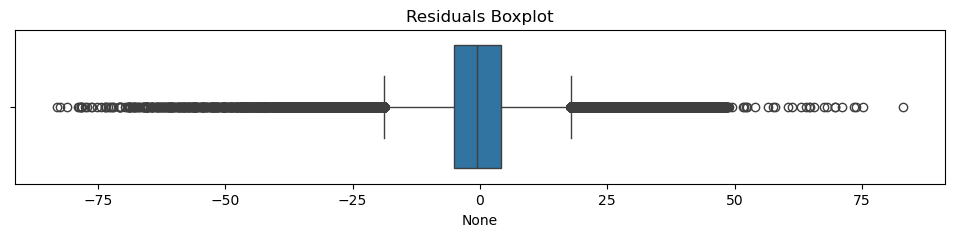

In [16]:
# === Inspect Residuals for Outliers ===
plt.figure(figsize=(12, 2))
sns.boxplot(x=residuals)
plt.title('Residuals Boxplot')
plt.show()

In [17]:
# Convert residuals to a 2D array for GMM (required shape: [n_samples, n_features])
residuals_array = residuals.values.reshape(-1, 1)
gmm_models = []  # Define and initialize the list

# Initialize a list to store diagnostics for each GMM with different numbers of components
gmm_diagnostics = []

# Loop over the number of components (1 through 5)
for k in range(1, 6):
    # Fit GMM with k components using a fixed random state for reproducibility
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)
    
    # Calculate the total log-likelihood from the per-sample log probabilities.
    # Note: score_samples returns the log probability for each sample.
    loglik_k = np.sum(gmm_k.score_samples(residuals_array))
    
    # Estimate the number of free parameters for a mixture of Gaussians.
    # For each component: 1 weight (but total weights sum to 1: hence, k - 1 free parameters),
    # 1 mean, and 1 variance. Total parameters: (k - 1) + k + k = 3k - 1.
    num_params = 3 * k - 1
    
    # Compute AIC and BIC using standard formulas:    
    aic_k = 2 * num_params - 2 * loglik_k
    bic_k = num_params * np.log(len(residuals_array)) - 2 * loglik_k
    
    # Perform a Kolmogorov–Smirnov (KS) test on the residuals versus the GMM cumulative distribution.
    # We use our custom gmm_cdf function defined earlier.
    ks_result = kstest(residuals, lambda x: gmm_cdf(x, gmm_k))
    
    # Append the diagnostics for the current model to our list
    gmm_diagnostics.append({
        'GMM Components': k,
        'Log-Likelihood': loglik_k,
        'AIC': aic_k,
        'BIC': bic_k,
        'KS Statistic': ks_result.statistic,
        'KS p-value': ks_result.pvalue
    })

# Convert the collected diagnostics to a DataFrame
gmm_diag_df = pd.DataFrame(gmm_diagnostics)

print("\n=== GMM Diagnostics (Modes 1-5) ===\n")
display(gmm_diag_df)

# Select the best GMM based on the minimum AIC value (or BIC)
best_gmm_row = gmm_diag_df.loc[gmm_diag_df['BIC'].idxmin()]
best_gmm_components = best_gmm_row['GMM Components']
best_gmm = gmm_models[int(best_gmm_components) - 1]
print(f"\nBest GMM Model based on lowest BIC: {int(best_gmm_components)} components\n")


=== GMM Diagnostics (Modes 1-5) ===



,GMM Components,Log-Likelihood,AIC,BIC,KS Statistic,KS p-value
0,1,-4.964494e+06,9.928991e+06,9.929015e+06,0.056453,0.000000e+00
1,2,-4.871297e+06,9.742604e+06,9.742665e+06,0.013186,2.933283e-214
2,3,-4.857229e+06,9.714473e+06,9.714571e+06,0.008222,1.459265e-83
3,4,-4.854169e+06,9.708360e+06,9.708494e+06,0.006248,1.936011e-48
4,5,-4.854666e+06,9.709359e+06,9.709530e+06,0.004985,5.443351e-31



Best GMM Model based on lowest BIC: 4 components



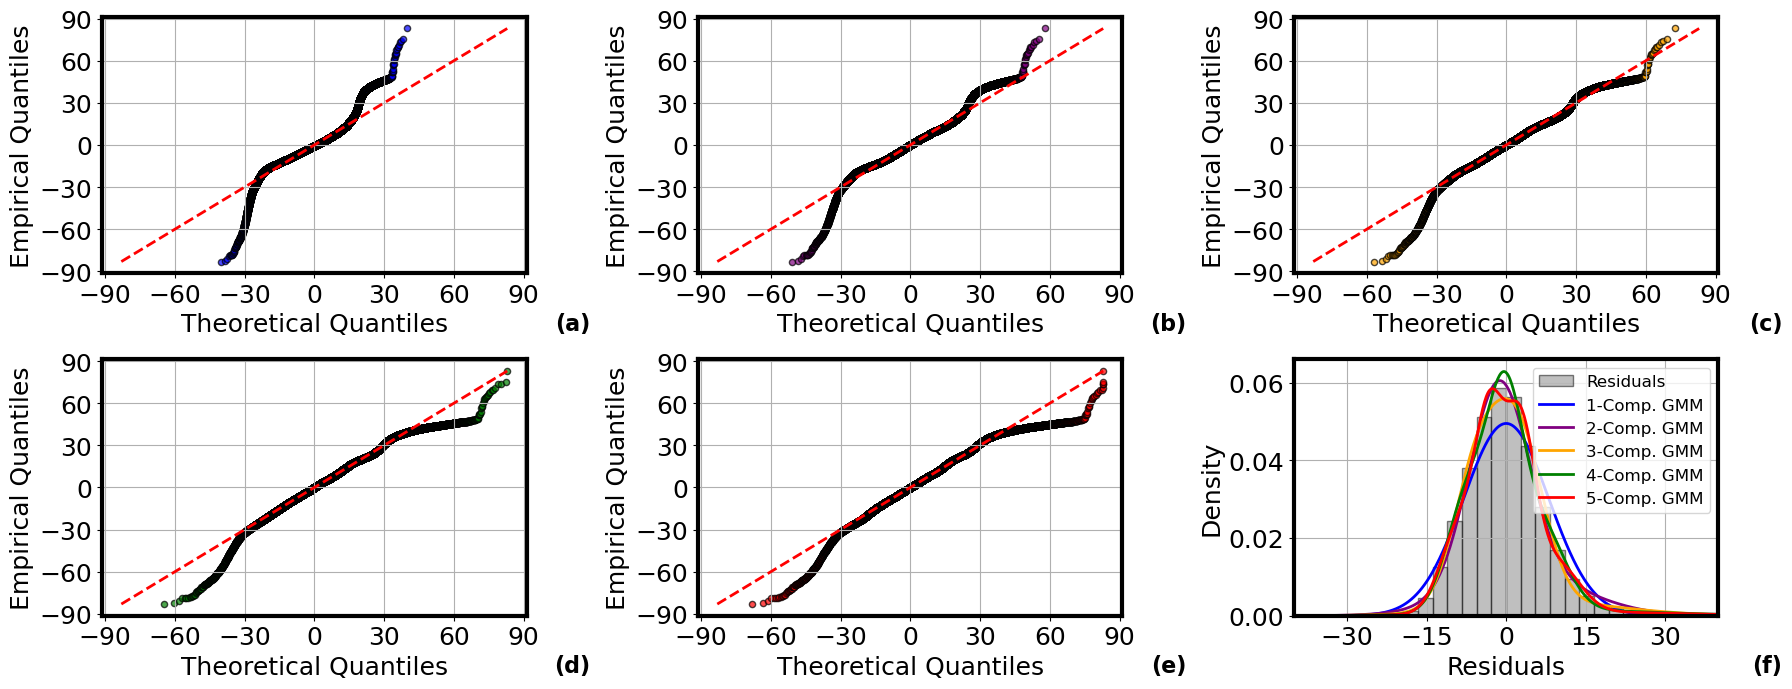

In [18]:
# --- Re-fit GMM models for 1 to 5 components and store them in a list ---
gmm_models = []
for k in range(1, 6):
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)

# Prepare sorted residuals and the corresponding probability positions
sorted_residuals = np.sort(residuals)
n = len(sorted_residuals)
probs = (np.arange(1, n + 1) - 0.5) / n  # Probability positions for quantiles

# --- Create a 2x3 grid for Q–Q plots and the combined histogram ---
fig, axes = plt.subplots(2, 3, figsize=(18, 7))
axes = axes.flatten()
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
gmm_colors = ['blue', 'purple', 'orange', 'green', 'red']

# --- Plot Q–Q plots for each of the 5 GMM models ---
for i, gmm_model in enumerate(gmm_models):
    ax = axes[i]
    
    # Generate a dense grid to compute the GMM CDF
    x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
    cdf_grid = gmm_cdf(x_grid, gmm_model)
    
    # Remove duplicate CDF values for reliable interpolation
    unique_cdf, unique_idx = np.unique(cdf_grid, return_index=True)
    unique_x = x_grid[unique_idx]
    # Create an interpolation function (PPF) from CDF to quantiles
    ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
    theoretical_quantiles = ppf_func(probs)
    
    # Scatter the theoretical versus empirical quantiles
    ax.scatter(theoretical_quantiles, sorted_residuals, color=gmm_colors[i], alpha=0.7, edgecolors='k', s=20)
    # Plot a 45° reference line
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    ax.set_xlabel('Theoretical Quantiles', fontsize=18)
    ax.set_ylabel('Empirical Quantiles', fontsize=18)
    #ax.set_title(f'GMM with {i+1} Component(s)', fontsize=20)
    ax.text(1.15, -0.15, subplot_labels[i], transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)
    ax.grid(True)

# --- Plot the 6th subplot: Histogram of residuals with overlaid GMM densities ---
ax6 = axes[5]
ax6.hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
for i, gmm_model in enumerate(gmm_models):
    # Compute the density for the current GMM (exponentiate the log probabilities)
    density = np.exp(gmm_model.score_samples(x_vals.reshape(-1, 1)))
    ax6.plot(x_vals, density, color=gmm_colors[i], linewidth=2, label=f'{i+1}-Comp. GMM')
    
ax6.set_xlabel('Residuals', fontsize=18)
ax6.set_ylabel('Density', fontsize=18)
ax6.legend(fontsize=12)
ax6.set_xlim(-40, 40)
ax6.grid(True)
ax6.text(1.15, -0.15, subplot_labels[5], transform=ax6.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)

# Set tick intervals and font sizes
for i, ax in enumerate(axes):
    if i < 5:  # Subplots (a) to (e)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.yaxis.set_major_locator(MultipleLocator(30))
    elif i == 5:  # Subplot (f)
        ax.xaxis.set_major_locator(MultipleLocator(15))
    
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(3)
        
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/gmm_qq_residual_plots.png', dpi=1000)
plt.show()

In [19]:
# --- Print Distribution Parameters Including Best GMM ---

def print_group(title, params):
    bold_title = f"\033[1m=== {title} ===\033[0m"
    print(bold_title)
    for name, val in params:
        print(f"{name}: {val:.4f}")
    print("-" * 50)

# Normal Distribution
print_group("Normal Distribution", [("Mean (μ)", loc_norm), ("Std (σ)", scale_norm)])

# Skew-Normal Distribution
print_group("Skew-Normal Distribution", [("Shape", shape_sn), ("Location", loc_sn), ("Scale", scale_sn)])

# Gaussian Mixture Model (Using Best GMM from Diagnostics)
bold_title = f"\033[1m=== Gaussian Mixture Model (Best GMM) ===\033[0m"
print(bold_title)
for i in range(best_gmm.n_components):
    print(f"Component {i+1}:")
    print(f"  Weight (π): {best_gmm.weights_[i]:.4f}")
    if best_gmm.covariances_.ndim == 3:
        std = np.sqrt(best_gmm.covariances_[i][0][0])
    else:
        std = np.sqrt(best_gmm.covariances_[i])
    mean = best_gmm.means_[i][0]
    print(f"  Mean (μ):   {mean:.4f}")
    print(f"  Std (σ):    {std:.4f}")
print("-" * 50)

# Cauchy Distribution
print_group("Cauchy Distribution", [("Location", cauchy_params[0]), ("Scale", cauchy_params[1])])

# t-Distribution
print_group("t-Distribution", [("Degrees of Freedom (df)", df_t), ("Location", loc_t), ("Scale", scale_t)])

=== Normal Distribution ===
Mean (μ): 0.0000
Std (σ): 8.0629
--------------------------------------------------
=== Skew-Normal Distribution ===
Shape: 1.8863
Location: -7.7417
Scale: 11.1779
--------------------------------------------------
=== Gaussian Mixture Model (Best GMM) ===
Component 1:
  Weight (π): 0.4265
  Mean (μ):   -0.2258
  Std (σ):    3.3990
Component 2:
  Weight (π): 0.2893
  Mean (μ):   -7.2532
  Std (σ):    3.9354
Component 3:
  Weight (π): 0.2226
  Mean (μ):   6.8126
  Std (σ):    4.3982
Component 4:
  Weight (π): 0.0616
  Mean (μ):   11.0169
  Std (σ):    17.2161
--------------------------------------------------
=== Cauchy Distribution ===
Location: -0.7026
Scale: 4.1993
--------------------------------------------------
=== t-Distribution ===
Degrees of Freedom (df): 4.7580
Location: -0.5223
Scale: 6.0823
--------------------------------------------------


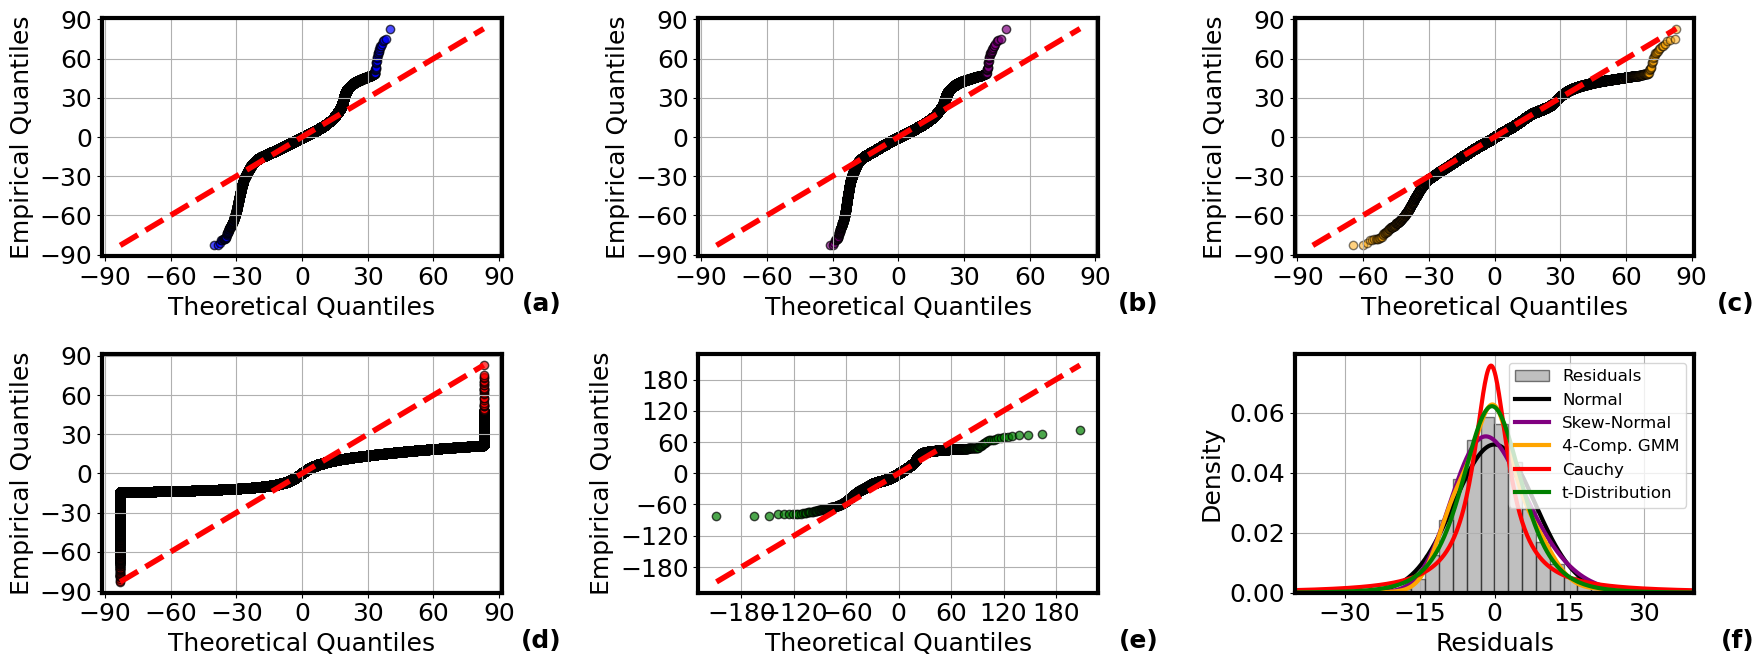

In [20]:
# === Plot Diagnostic Subplots in a 2x3 Grid ===
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'legend.fontsize': 15
})

fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Define subplot labels for the six subplots
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Function to create manual Q-Q plots
def manual_qq_plot(distribution, dist_name, sorted_residuals, probabilities, ax, color='blue'):
    """
    Create a manual Q-Q plot.
    """
    theoretical_quantiles = distribution.ppf(probabilities)
    ax.scatter(theoretical_quantiles, sorted_residuals, edgecolors='k', facecolor=color, alpha=0.7)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
    #ax.set_title(f'{dist_name} Distribution')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Empirical Quantiles')
    ax.grid(True)

# 1. Q-Q Plot (Normal Distribution)
manual_qq_plot(normal_dist, 'Normal', sorted_residuals, probabilities, axes[0], color='blue')
axes[0].text(1.15, -0.15, subplot_labels[0], transform=axes[0].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 2. Q-Q Plot (Skew-Normal Distribution)
manual_qq_plot(skew_dist, 'Skew-Normal', sorted_residuals, probabilities, axes[1], color='purple')
axes[1].text(1.15, -0.15, subplot_labels[1], transform=axes[1].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 3. Q-Q Plot (Gaussian Mixture Model)
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)  # Using best_gmm here
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)

axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals, edgecolors='k', facecolor='orange', alpha=0.5)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
#axes[2].set_title('GMM Distribution')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Empirical Quantiles')
axes[2].grid(True)
axes[2].text(1.15, -0.15, subplot_labels[2], transform=axes[2].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 4. Q-Q Plot (Cauchy Distribution)
lower_bound = residuals.min()
upper_bound = residuals.max()
theoretical_quantiles = cauchy_dist.ppf(probabilities)
theoretical_quantiles_clipped = np.clip(theoretical_quantiles, lower_bound, upper_bound)

axes[3].scatter(theoretical_quantiles_clipped, sorted_residuals, edgecolors='k', facecolor='red', alpha=0.7)
axes[3].plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'r--', linewidth=4)
#axes[3].set_title('Cauchy Distribution')
axes[3].set_xlabel('Theoretical Quantiles')
axes[3].set_ylabel('Empirical Quantiles')
axes[3].grid(True)
axes[3].text(1.15, -0.15, subplot_labels[3], transform=axes[3].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 5. Q-Q Plot (t-Distribution)
manual_qq_plot(t_dist, 't-', sorted_residuals, probabilities, axes[4], color='green')
axes[4].text(1.15, -0.15, subplot_labels[4], transform=axes[4].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 6. Residuals Histogram with Fitted Densities
axes[5].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=3)
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=3)
# Using best_gmm to compute density
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[5].plot(x_vals, gmm_density, label='4-Comp. GMM', color='orange', linewidth=3)
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=3)
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=3)
#axes[5].set_title('Residuals Distributions')
axes[5].set_xlabel('Residuals')
axes[5].set_ylabel('Density')
axes[5].legend(fontsize=12)
axes[5].grid(True)
axes[5].set_xlim(-40, 40)
axes[5].text(1.15, -0.15, subplot_labels[5], transform=axes[5].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# ----- Tick Interval Adjustments  -----
# For subplots a-d (axes[0] to axes[3]), 30
for i in range(0, 4):
    axes[i].xaxis.set_major_locator(MultipleLocator(30))
    axes[i].yaxis.set_major_locator(MultipleLocator(30))

# For subplot e (axes[4]), 60
axes[4].xaxis.set_major_locator(MultipleLocator(60))
axes[4].yaxis.set_major_locator(MultipleLocator(60))

# For histogram subplot f (axes[5]), 15
axes[5].xaxis.set_major_locator(MultipleLocator(15))
# ----- End of Tick Interval Adjustments -----

# Adjust tick font size for all subplots
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=18)

# Set all subplot border widths (spines) to 3 
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(3)

# Adjust layout, save figure, and display
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/qq_residual_plots.png', dpi=1000)
plt.show()

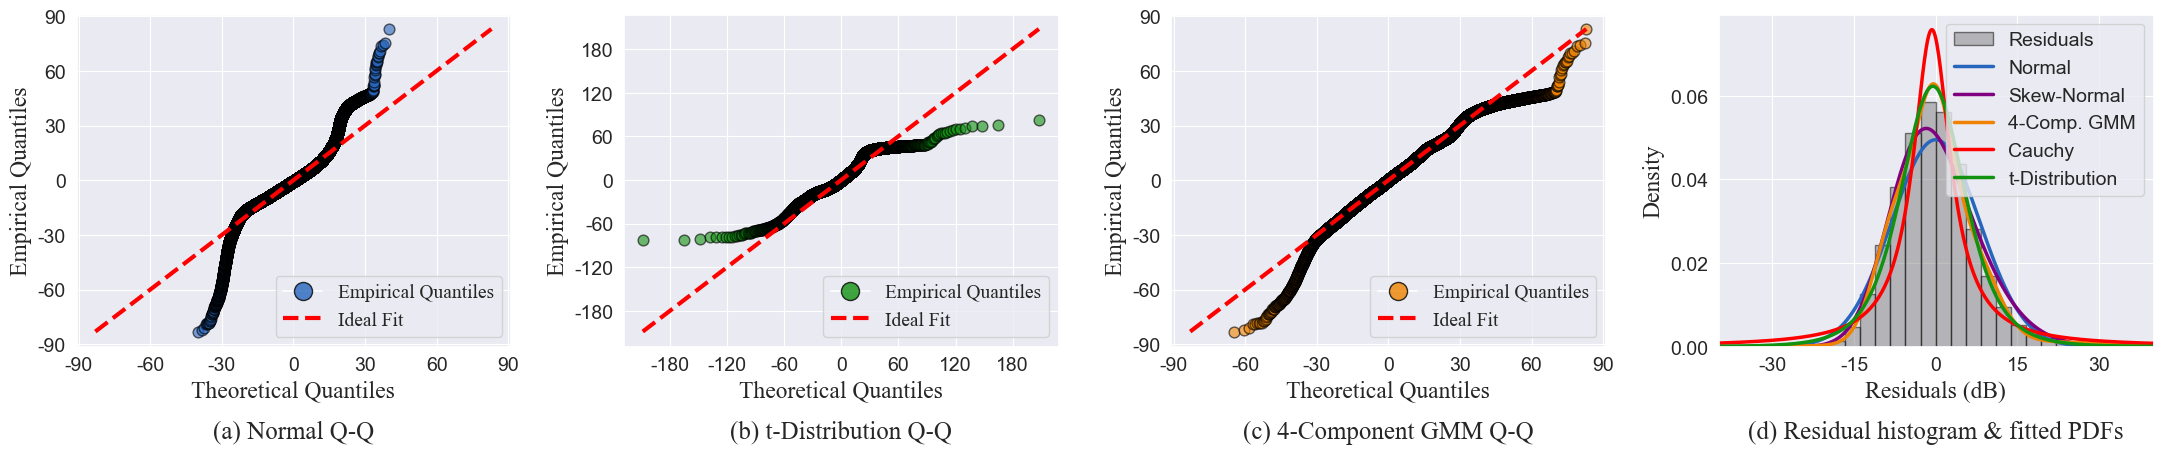

In [21]:
# ---- ENSURE TIMES NEW ROMAN EVERYWHERE ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.unicode_minus'] = False

# ---- FONT SIZE METRICS ----
tick_fontsize   = 14
axis_labelsize  = 17
legend_fontsize = 14
ab_fontsize     = 18
label_ypos      = -0.22   # position for (a)-(d) label

sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
qq_colors = ['#2766bd', '#119211', '#ef8301']  # blue, green, orange

# -- (a) Normal Q-Q --
theoretical_norm = normal_dist.ppf(probabilities)
axes[0].scatter(theoretical_norm, sorted_residuals,
                edgecolor='k', facecolor=qq_colors[0], alpha=0.6, s=60)
min_val = min(theoretical_norm.min(), sorted_residuals.min())
max_val = max(theoretical_norm.max(), sorted_residuals.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)
axes[0].set_xlabel('Theoretical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[0].set_ylabel('Empirical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0].xaxis.set_major_locator(MultipleLocator(30))
axes[0].yaxis.set_major_locator(MultipleLocator(30))
axes[0].text(0.5, label_ypos, '(a) Normal Q-Q', transform=axes[0].transAxes,
             fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
for spine in axes[0].spines.values():
    spine.set_linewidth(2.0)
legend_a = [
    Line2D([0], [0], marker='o', color='w', label='Empirical Quantiles',
           markerfacecolor=qq_colors[0], markeredgecolor='k', markersize=10, alpha=0.8),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Ideal Fit'),
]
leg1 = axes[0].legend(handles=legend_a, fontsize=legend_fontsize, loc='lower right',
                      handlelength=2, markerscale=1.3, frameon=True)
for t in leg1.get_texts():
    t.set_fontname('Times New Roman')

# -- (b) t-Distribution Q-Q --
theoretical_t = t_dist.ppf(probabilities)
axes[1].scatter(theoretical_t, sorted_residuals,
                edgecolor='k', facecolor=qq_colors[1], alpha=0.6, s=60)
min_val = min(theoretical_t.min(), sorted_residuals.min())
max_val = max(theoretical_t.max(), sorted_residuals.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)
axes[1].set_xlabel('Theoretical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[1].set_ylabel('Empirical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1].xaxis.set_major_locator(MultipleLocator(60))
axes[1].yaxis.set_major_locator(MultipleLocator(60))
axes[1].text(0.5, label_ypos, '(b) t-Distribution Q-Q', transform=axes[1].transAxes,
             fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
for spine in axes[1].spines.values():
    spine.set_linewidth(2.0)
legend_b = [
    Line2D([0], [0], marker='o', color='w', label='Empirical Quantiles',
           markerfacecolor=qq_colors[1], markeredgecolor='k', markersize=10, alpha=0.8),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Ideal Fit'),
]
leg2 = axes[1].legend(handles=legend_b, fontsize=legend_fontsize, loc='lower right',
                      handlelength=2, markerscale=1.3, frameon=True)
for t in leg2.get_texts():
    t.set_fontname('Times New Roman')

# -- (c) 4-comp GMM Q-Q --
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]
from scipy.interpolate import interp1d
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)
axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals,
                edgecolor='k', facecolor=qq_colors[2], alpha=0.6, s=60)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)
axes[2].set_xlabel('Theoretical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[2].set_ylabel('Empirical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[2].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[2].xaxis.set_major_locator(MultipleLocator(30))
axes[2].yaxis.set_major_locator(MultipleLocator(30))
axes[2].text(0.5, label_ypos, '(c) 4-Component GMM Q-Q', transform=axes[2].transAxes,
             fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
for spine in axes[2].spines.values():
    spine.set_linewidth(2.0)
legend_c = [
    Line2D([0], [0], marker='o', color='w', label='Empirical Quantiles',
           markerfacecolor=qq_colors[2], markeredgecolor='k', markersize=10, alpha=0.8),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Ideal Fit'),
]
leg3 = axes[2].legend(handles=legend_c, fontsize=legend_fontsize, loc='lower right',
                      handlelength=2, markerscale=1.3, frameon=True)
for t in leg3.get_texts():
    t.set_fontname('Times New Roman')

# -- (d) Residuals Histogram with All Fitted PDFs --
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[3].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
axes[3].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='#2766bd', linewidth=2.5)
axes[3].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=2.5)
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[3].plot(x_vals, gmm_density, label='4-Comp. GMM', color='#ef8301', linewidth=2.5)
axes[3].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=2.5)
axes[3].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='#119211', linewidth=2.5)
axes[3].set_xlabel('Residuals (dB)', fontsize=axis_labelsize, fontname='Times New Roman')
axes[3].set_ylabel('Density', fontsize=axis_labelsize, fontname='Times New Roman')
axes[3].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[3].set_xlim(-40, 40)
axes[3].legend(fontsize=legend_fontsize, loc='upper right')
axes[3].text(0.5, label_ypos, '(d) Residual histogram & fitted PDFs', transform=axes[3].transAxes,
             fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
axes[3].xaxis.set_major_locator(MultipleLocator(15))
axes[3].yaxis.set_major_locator(MultipleLocator(0.02))
for spine in axes[3].spines.values():
    spine.set_linewidth(2.0)

plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots./residualdistributionanalysis.png', dpi=1200, bbox_inches='tight')
plt.show()

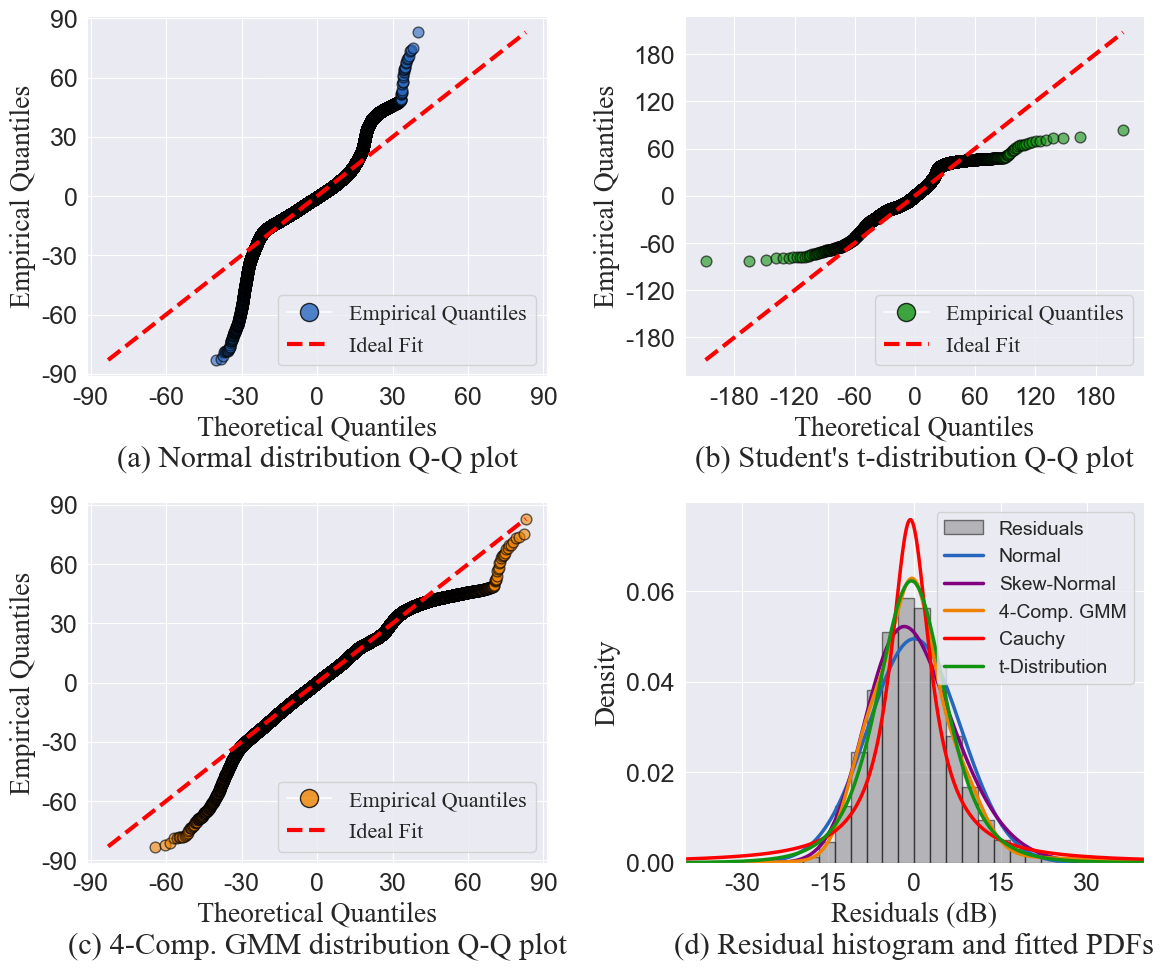

In [22]:
# ---- ENSURE TIMES NEW ROMAN EVERYWHERE ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.unicode_minus'] = False

# ---- FONT SIZE METRICS ----
tick_fontsize   = 18
axis_labelsize  = 20
legend_fontsize = 16
ab_fontsize     = 22
label_ypos      = -0.19   # vertical position for (a)-(d) labels

sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
qq_colors = ['#2766bd', '#119211', '#ef8301']  # blue, green, orange

# (a) Normal Q-Q (axes[0,0])
theoretical_norm = normal_dist.ppf(probabilities)
axes[0, 0].scatter(theoretical_norm, sorted_residuals,
                   edgecolor='k', facecolor=qq_colors[0], alpha=0.6, s=60)
min_val = min(theoretical_norm.min(), sorted_residuals.min())
max_val = max(theoretical_norm.max(), sorted_residuals.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)
axes[0, 0].set_xlabel('Theoretical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[0, 0].set_ylabel('Empirical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[0, 0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0, 0].xaxis.set_major_locator(MultipleLocator(30))
axes[0, 0].yaxis.set_major_locator(MultipleLocator(30))
axes[0, 0].text(0.5, label_ypos, '(a) Normal distribution Q-Q plot', transform=axes[0, 0].transAxes,
                fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
legend_a = [
    Line2D([0], [0], marker='o', color='w', label='Empirical Quantiles',
           markerfacecolor=qq_colors[0], markeredgecolor='k', markersize=10, alpha=0.8),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Ideal Fit'),
]
leg1 = axes[0, 0].legend(handles=legend_a, fontsize=legend_fontsize, loc='lower right',
                         handlelength=2, markerscale=1.3, frameon=True)
for t in leg1.get_texts():
    t.set_fontname('Times New Roman')

# (b) t-Distribution Q-Q (axes[0,1])
theoretical_t = t_dist.ppf(probabilities)
axes[0, 1].scatter(theoretical_t, sorted_residuals,
                   edgecolor='k', facecolor=qq_colors[1], alpha=0.6, s=60)
min_val = min(theoretical_t.min(), sorted_residuals.min())
max_val = max(theoretical_t.max(), sorted_residuals.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)
axes[0, 1].set_xlabel('Theoretical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[0, 1].set_ylabel('Empirical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[0, 1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0, 1].xaxis.set_major_locator(MultipleLocator(60))
axes[0, 1].yaxis.set_major_locator(MultipleLocator(60))
axes[0, 1].text(0.5, label_ypos, '(b) Student\'s t-distribution Q-Q plot', transform=axes[0, 1].transAxes,
                fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
legend_b = [
    Line2D([0], [0], marker='o', color='w', label='Empirical Quantiles',
           markerfacecolor=qq_colors[1], markeredgecolor='k', markersize=10, alpha=0.8),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Ideal Fit'),
]
leg2 = axes[0, 1].legend(handles=legend_b, fontsize=legend_fontsize, loc='lower right',
                         handlelength=2, markerscale=1.3, frameon=True)
for t in leg2.get_texts():
    t.set_fontname('Times New Roman')

# (c) 4-comp GMM Q-Q (axes[1,0])
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]

ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)
axes[1, 0].scatter(theoretical_gmm_quantiles, sorted_residuals,
                   edgecolor='k', facecolor=qq_colors[2], alpha=0.6, s=60)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3)
axes[1, 0].set_xlabel('Theoretical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[1, 0].set_ylabel('Empirical Quantiles', fontsize=axis_labelsize, fontname='Times New Roman')
axes[1, 0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1, 0].xaxis.set_major_locator(MultipleLocator(30))
axes[1, 0].yaxis.set_major_locator(MultipleLocator(30))
axes[1, 0].text(0.5, label_ypos, '(c) 4-Comp. GMM distribution Q-Q plot', transform=axes[1, 0].transAxes,
                fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
legend_c = [
    Line2D([0], [0], marker='o', color='w', label='Empirical Quantiles',
           markerfacecolor=qq_colors[2], markeredgecolor='k', markersize=10, alpha=0.8),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Ideal Fit'),
]
leg3 = axes[1, 0].legend(handles=legend_c, fontsize=legend_fontsize, loc='lower right',
                         handlelength=2, markerscale=1.3, frameon=True)
for t in leg3.get_texts():
    t.set_fontname('Times New Roman')

# (d) Residuals Histogram with Fitted PDFs (axes[1,1])
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[1, 1].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
axes[1, 1].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='#2766bd', linewidth=2.5)
axes[1, 1].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=2.5)
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[1, 1].plot(x_vals, gmm_density, label='4-Comp. GMM', color='#ef8301', linewidth=2.5)
axes[1, 1].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=2.5)
axes[1, 1].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='#119211', linewidth=2.5)
axes[1, 1].set_xlabel('Residuals (dB)', fontsize=axis_labelsize, fontname='Times New Roman')
axes[1, 1].set_ylabel('Density', fontsize=axis_labelsize, fontname='Times New Roman')
axes[1, 1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1, 1].set_xlim(-40, 40)
axes[1, 1].legend(fontsize=14, loc='upper right')
axes[1, 1].text(0.5, label_ypos, '(d) Residual histogram and fitted PDFs', transform=axes[1, 1].transAxes,
                fontsize=ab_fontsize, va='top', ha='center', fontname='Times New Roman')
axes[1, 1].xaxis.set_major_locator(MultipleLocator(15))
axes[1, 1].yaxis.set_major_locator(MultipleLocator(0.02))

plt.tight_layout(w_pad=0.0, h_pad=2.5)

plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots./residualdistributionanalysis.png', dpi=1200, bbox_inches='tight')
plt.show()